In [1]:
import numpy as np
from equilibrator_api import ComponentContribution, Q_
from equilibrator_assets.generate_compound import create_compound, get_or_create_compound
from rdkit import Chem
from equilibrator_api import Reaction
from equilibrator_cache import Q_
from component_contribution.predict import GibbsEnergyPredictor

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
%config InlineBackend.figure_format ='retina'

from numpyarray_to_latex.jupyter import to_jup

In [2]:
cc = ComponentContribution()

cc.p_h = Q_(7.5)
cc.p_mg = Q_(0)
cc.ionic_strength = Q_("0.25M")
T = 298.15
R = 8.31446261815324
cc.temperature = Q_(f"{T}K")

GP = GibbsEnergyPredictor()

cond = {
    'p_h': cc.p_h ,
    'ionic_strength': cc.ionic_strength,
    'temperature': cc.temperature,
    'p_mg': cc.p_mg
}

In [82]:
# define smiles
alcohol_smi = "OCC1=CC=CC=C1"
aldehyde_smi = "O=CC1=CC=CC=C1"
amine_substrate_smi = "NC1CC1"  # cyclopropylamine
amine_product_smi = "C(NC1CC1)C1=CC=CC=C1"  # benzyaldehyde + cycloproylamine product
list_smis = [alcohol_smi, aldehyde_smi, amine_substrate_smi, amine_product_smi]

In [83]:
# get compounds for use with equilibrator
compounds = get_or_create_compound(cc.ccache, list_smis, mol_format="smiles")

alcohol = compounds[0]
aldehyde = compounds[1]
amine_substrate = compounds[2]
amine_product = compounds[3]

nadph = cc.search_compound("nadph")
nadp = cc.search_compound("nadp")
h2o = cc.search_compound("h2o")

In [84]:
adh_reaction = Reaction({alcohol: -1, 
                         nadp: -1,
                         aldehyde: +1,
                         nadph: +1,})

ired_reaction = Reaction({aldehyde: -1, 
                          nadph: -1,
                          amine_substrate: -1,
                          amine_product: +1,
                          nadp: +1,
                          h2o: +1})

reactions = [adh_reaction, ired_reaction]

print(f'is balanced = {adh_reaction.is_balanced()}')
print(f'is balanced = {ired_reaction.is_balanced()}')

is balanced = True
is balanced = True


In [85]:
adh_reaction

## Equilibrium constant
$\Delta G^\circ = -R T ln K_{eq}$  
  
$K_{eq} = e^{-\Delta G^\circ / RT}$

In [86]:
def calc_keq(reaction, pH=7.5):
    ''' returns the Keq for a given reaction '''
    
    cc.p_h = Q_(pH)
    dG0_prime = cc.standard_dg_prime(reaction).value.m_as("J/mol")
    keq = np.exp(-dG0_prime/(R*T))
    return keq

## ADH reaction equilibrium and response to pH

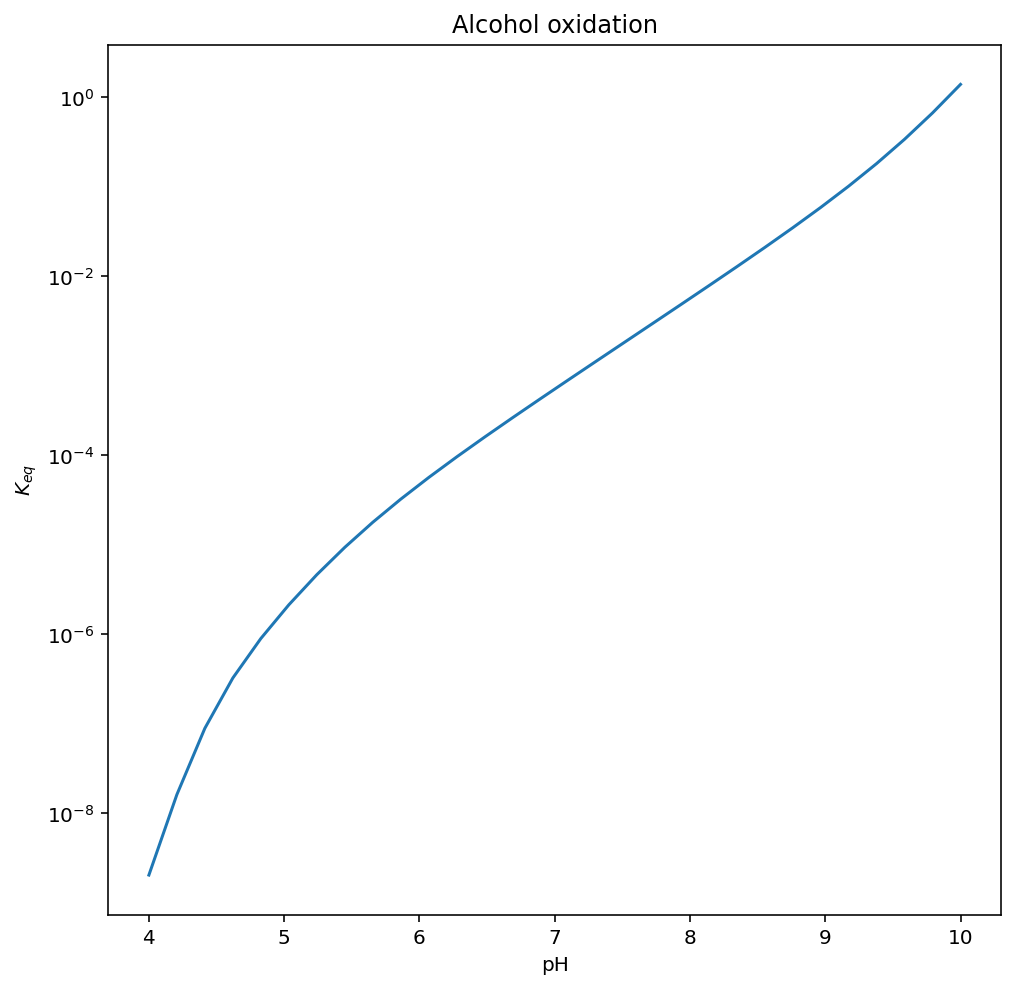

In [87]:
ph_range = np.linspace(4, 10, 30)
plt.plot(ph_range, [calc_keq(adh_reaction, pH=pH) for pH in ph_range], '-')
plt.xlabel("pH")
plt.ylabel(r"$K_{eq}$")
plt.yscale('log')
plt.title("Alcohol oxidation")
plt.show()

## IRED reaction equilibrium and response to pH

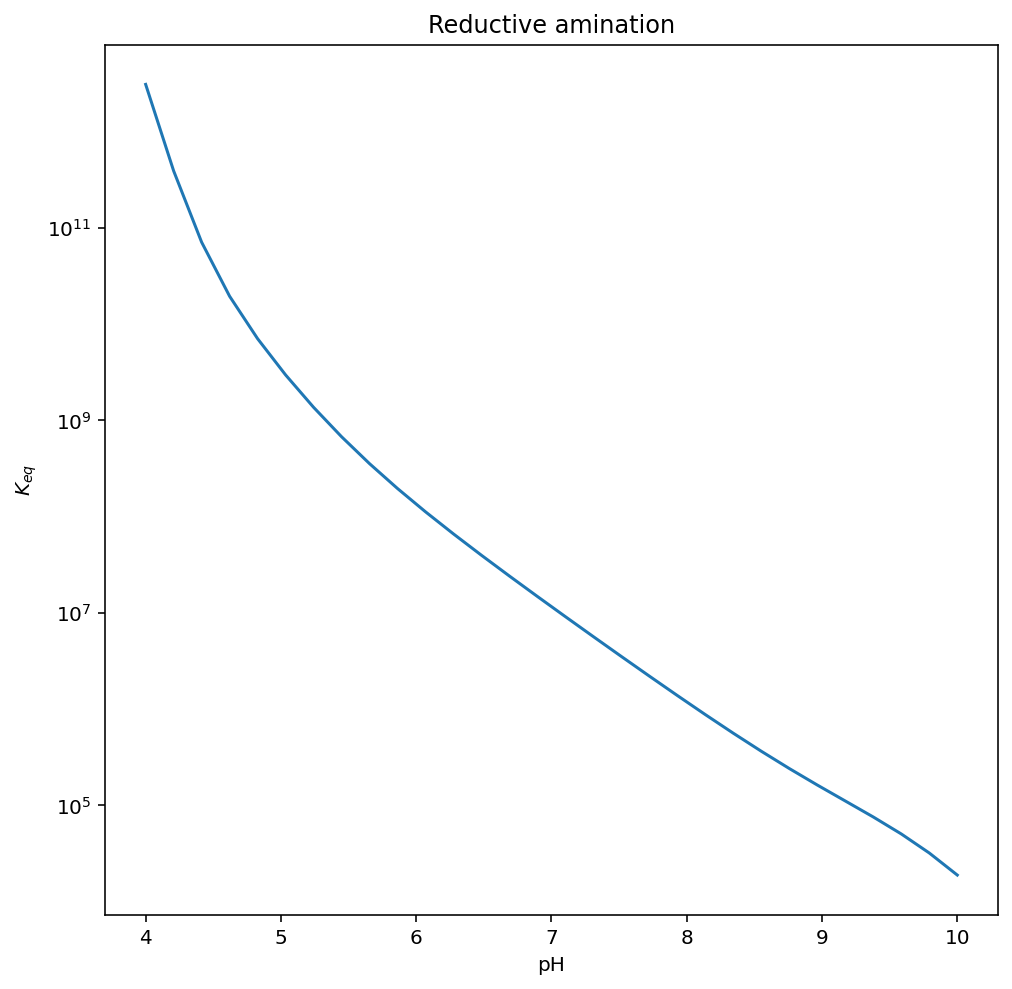

In [88]:
ph_range = np.linspace(4, 10, 30)
plt.plot(ph_range, [calc_keq(ired_reaction, pH=pH) for pH in ph_range], '-')
plt.xlabel("pH")
plt.ylabel(r"$K_{eq}$")
plt.yscale('log')
plt.title("Reductive amination")
plt.show()

## Correlated gibbs free energy calculation
Equilibrator will try to minimise variance where it can.  Because of this, reactions in a system can have correlated error for the estimate for gibbs free energy.  We can plot this to see..

In [89]:
standard_dgr_prime_mean, standard_dgr_Q = cc.standard_dg_prime_multi(reactions, uncertainty_representation="fullrank")

print(f"mean (μ) in kJ / mol:")
to_jup(standard_dgr_prime_mean.m_as("kJ/mol"))
print(f"square root (Q) in kJ / mol:")
to_jup(standard_dgr_Q.m_as("kJ/mol"))
print(f"covariance in (kJ / mol)^2:")
to_jup((standard_dgr_Q @ standard_dgr_Q.T).m_as("kJ**2/mol**2"))

mean (μ) in kJ / mol:


<IPython.core.display.Math object>

square root (Q) in kJ / mol:


<IPython.core.display.Math object>

covariance in (kJ / mol)^2:


<IPython.core.display.Math object>

## Sample correlated gibbs free energy

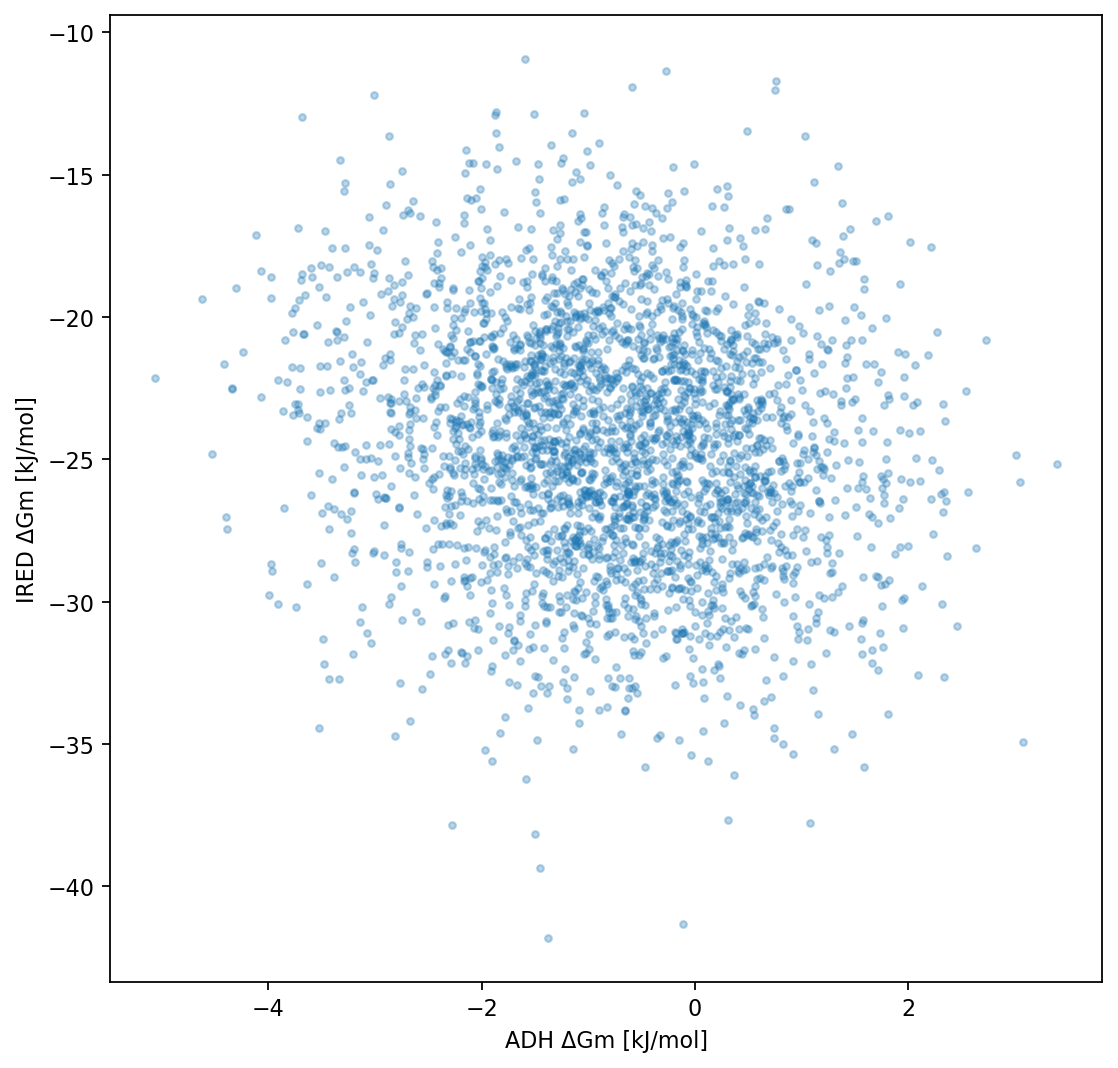

In [90]:
np.random.seed(2019)
N = 3000
sampled_data = []
for i in range(N):
    m = np.random.randn(standard_dgr_Q.shape[1])
    standard_dgr_prime_sample = standard_dgr_prime_mean + standard_dgr_Q @ m
    sampled_data.append(standard_dgr_prime_sample.m_as("kJ/mol"))
sampled_data = np.array(sampled_data)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=80)
ax.plot(sampled_data[:, 0], sampled_data[:, 1], '.', alpha=0.3)
ax.set_xlabel("ADH ΔGm [kJ/mol]")
ax.set_ylabel("IRED ΔGm [kJ/mol]");
#ax.set_aspect("equal")

## Equilibrium constants

In [91]:
from math import log10, floor
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [92]:
def calc_keq(reaction, pH=7.5):
    ''' returns the Keq for a given reaction, with error '''
    
    cc.p_h = Q_(pH)
    dG0_prime = cc.standard_dg_prime(reaction)
    dG0_prime_j_mol = dG0_prime.value.m_as("J/mol")
    dG0_prime_j_mol_error = dG0_prime.error.m_as("J/mol")
    
    dG0_prime_lower = dG0_prime_j_mol - dG0_prime_j_mol_error
    dG0_prime_upper = dG0_prime_j_mol + dG0_prime_j_mol_error
    lower_upper = sorted([dG0_prime_lower, dG0_prime_upper], reverse=True)
    
    keq = round_sig(np.exp(-dG0_prime_j_mol/(R*T)))
    keq_lower = round_sig(np.exp(-lower_upper[0]/(R*T)))
    keq_upper = round_sig(np.exp(-lower_upper[1]/(R*T)))

    #keq_error = np.exp(-dG0_prime_j_mol_error/(R*T))
    
    return keq, [keq_lower, keq_upper]

In [81]:
adh_keq, adh_keq_error = calc_keq(adh_reaction, pH=7.5)
print(f"ADH Keq = {adh_keq} ± {adh_keq_error}")
 
ired_keq, ired_keq_error = calc_keq(ired_reaction, pH=7.5)
print(f"IRED Keq = {ired_keq} ± {ired_keq_error}")

ADH Keq = 0.00175 ± [0.00106, 0.00289]
IRED Keq = 3640000.0 ± [642000.0, 20600000.0]
